# Calculate Coverage

You've defined an AOI, you've specified the image type you are interested and the search query. Great! But what is the coverage of your AOI given your search query? Wouldn't you like to know before you start downloading images?

This notebook will allow you to answer that question quickly and painlessly.

Coverage calculation is performed in the UTM [projected coordinate system](http://resources.arcgis.com/en/help/main/10.1/index.html#//003r0000000p000000). The geojson features are defined in the WGS84 [geographic coordinate system](http://resources.arcgis.com/en/help/main/10.1/index.html#//003r00000006000000), which is not a 2D projection. 
UTM preserves shape and minimizes distortion ([wikipedia](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system))

In [119]:
# Notebook dependencies
from __future__ import print_function

import datetime
import copy
from functools import partial
import geopandas as gpd
import os

from IPython.display import display, Image
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from planet import Auth
from planet import Session, DataClient, OrdersClient
import pyproj
import rasterio
from rasterio import features as rfeatures
from shapely.ops import transform
from shapely.geometry import shape
import shapely.ops

%matplotlib inline

## Define AOI

Define the AOI as a geojson polygon. This can be done at [geojson.io](http://geojson.io). If you use geojson.io, only copy the single aoi feature, not the entire feature collection.

In [ ]:
# define test data for the filter

# AOI: Cary, NC
test_aoi_geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-78.83102416992188, 35.86345667898701],
            [-78.88458251953125, 35.8250510782599],
            [-78.88801574707031, 35.747905467846515],
            [-78.8540267944336, 35.755149755962755],
            [-78.79291534423828, 35.74121784739981],
            [-78.74141693115234, 35.76740781814028],
            [-78.75274658203125, 35.78495584591914],
            [-78.74038696289062, 35.813915544045656],
            [-78.77986907958984, 35.83757668704619],
            [-78.83102416992188, 35.86345667898701]
        ]
    ]
}


# this notebook uses rasterio Shapes for processing, so lets convert that geojson to a shape
aoi_shape = shape(test_aoi_geom)


### Let's search:
# for the geometry above
# Date Range: June 1st - Oct 31st 2016
# Cloud Cover: less than 0.5 of the image should be covered with clouds

## Build Request

Build the Planet API Filter request.

Customize this code for your own purposes

In [123]:
# create an API Request from the search specifications

item_type = ['PSOrthoTile']

geom_filter = {
   "type":"GeometryFilter",
   "field_name":"geometry",
   "config":test_aoi_geom
}

cloud_cover_filter = {
"type":"RangeFilter",
"field_name":"cloud_cover",
"config":{
  "lt":0.5}
}

date_range_filter = {
"type":"DateRangeFilter",
"field_name":"acquired",
"config":{
  "gt":"2016-06-01T00:00:00Z", 
   "lt": "2016-10-01T00:00:00Z"}
}

combined_filter = {
"type":"AndFilter",
"config":[
    geom_filter,
    date_range_filter,
    cloud_cover_filter]
}

async with Session() as sess:
    cl = DataClient(sess)
    request = await cl.create_search(name='calc_coverage_search',search_filter=combined_filter, item_types=item_type)


In [124]:
# Let's look at our search request.
# Note: This is just the request's structure, the search hasn't been implemented yet
request

{'__daily_email_enabled': False,
 '_links': {'_self': 'https://api.planet.com/data/v1/searches/61946aef0574468fb7f0375e3f2be0e7',
  'results': 'https://api.planet.com/data/v1/searches/61946aef0574468fb7f0375e3f2be0e7/results'},
 'created': '2022-08-16T20:23:48.794876Z',
 'filter': {'config': [{'config': {'coordinates': [[[-93.299129, 42.699599],
       [-93.299674, 42.812757],
       [-93.288436, 42.861921],
       [-93.265332, 42.924817],
       [-92.993873, 42.925124],
       [-92.993888, 42.773637],
       [-92.998396, 42.754529],
       [-93.019154, 42.699988],
       [-93.299129, 42.699599]]],
     'type': 'Polygon'},
    'field_name': 'geometry',
    'type': 'GeometryFilter'},
   {'config': {'gt': '2016-06-01T00:00:00Z', 'lt': '2016-10-01T00:00:00Z'},
    'field_name': 'acquired',
    'type': 'DateRangeFilter'},
   {'config': {'lt': 0.5},
    'field_name': 'cloud_cover',
    'type': 'RangeFilter'}],
  'type': 'AndFilter'},
 'id': '61946aef0574468fb7f0375e3f2be0e7',
 'item_types':

## Check AOI and Determine Coverage Grid Dimensions

We convert the AOI to UTM and ensure that it is large enough to include at least a few grid cells 9m x 9m (approximately 3x PS Orthotile resolution). Then we determine the appropriate coverage grid dimensions from the AOI.

There are a lot of UTM zones, and the UTM zone we project to depends on the location of the AOI. Once this zone is determined, we create a function that can be used to project any shape. We will use that function to project the scene footprints to the same UTM zone once we get them.

In [126]:
# Utility functions: projecting a feature to the appropriate UTM zone

def get_utm_projection_fcn(geom):
    # define projection
    # from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
    proj_fcn = partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'), #wgs84
        _get_utm_projection(geom))
    return proj_fcn


def _get_utm_zone(geom):
    '''geom: geojson geometry'''
    coordinates = shape(geom)
    lon = coordinates.centroid.x
    lat = coordinates.centroid.y
    
    if lat > 84 or lat < -80:
        raise Exception('UTM Zones only valid within [-80, 84] latitude')
    
    # this is adapted from
    # https://www.e-education.psu.edu/natureofgeoinfo/book/export/html/1696
    zone = int((lon + 180) / 6 + 1)
    
    hemisphere = 'north' if lat > 0 else 'south'
    
    return (zone, hemisphere)


def _get_utm_projection(geom):
    proj_str = "EPSG:32617"
    return pyproj.Proj(proj_str)


proj_fcn = get_utm_projection_fcn(aoi_shape)
aoi_shape_utm = shapely.ops.transform(proj_fcn, aoi_shape)


/Users/mansi/Documents/Code/notebooks/notebooks_env/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [127]:
def get_coverage_dimensions(aoi_shape_utm):
    '''Checks that aoi is big enough and calculates the dimensions for coverage grid.'''
    minx, miny, maxx, maxy = aoi_shape_utm.bounds
    width = maxx - minx
    height = maxy - miny
    
    min_cell_size = 9 # in meters, approx 3x ground sampling distance
    min_number_of_cells = 3
    max_number_of_cells = 3000
    
    
    min_dim = min_cell_size * min_number_of_cells
    if height < min_dim:
        raise Exception('AOI height too small, should be {}m.'.format(min_dim))

    if width < min_dim:
        raise Exception('AOI width too small, should be {}m.'.format(min_dim))
    
    def _dim(length):
        return min(int(length/min_cell_size), max_number_of_cells)

    return [_dim(l) for l in (height, width)]


dimensions = get_coverage_dimensions(aoi_shape_utm)
print(dimensions)

[3000, 3000]


## Search using the Planet Data API

The client is how we interact with the Planet API. It is created with the user-specific API Key, which is pulled from $PL_API_KEY environment variable.

Unless you are expecting over 500 images (in which case, why are you concerned about coverage?), this code doesn't need to be altered.

Here we'll use the quick search functionality that saves searches for up to a month!

In [130]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_API_KEY_HERE')

client = Auth.from_key(API_KEY)

# Use our API key as the basic authentication username
apiAuth = (API_KEY, '')

In [131]:
async with Session() as sess:
    cl = DataClient(sess)
    items = await cl.quick_search(name='calc_coverage_search',search_filter=combined_filter, item_types=item_type, limit=500)
    item_list = [i async for i in items]

## Calculate Coverage

First query the planet api for the items that match the request defined above, then calculate the overlap between each item and the aoi. Finally, convert each overlap to a grid using [`rasterio.rasterize`](https://mapbox.github.io/rasterio/topics/features.html#burning-shapes-into-a-raster), accumulate coverage over the overlap grids, and display the coverage grid.

In [132]:
# Let's look at the list of items that match our quick search

item_list

[{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSOrthoTile/items/234187_1558813_2016-09-06_0e19',
   'assets': 'https://api.planet.com/data/v1/item-types/PSOrthoTile/items/234187_1558813_2016-09-06_0e19/assets/',
   'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSOrthoTile/items/234187_1558813_2016-09-06_0e19/thumb'},
  '_permissions': ['assets.analytic:download',
   'assets.analytic_dn:download',
   'assets.analytic_dn_xml:download',
   'assets.analytic_sr:download',
   'assets.analytic_xml:download',
   'assets.udm:download',
   'assets.visual:download',
   'assets.visual_xml:download'],
  'assets': ['analytic',
   'analytic_dn',
   'analytic_dn_xml',
   'analytic_sr',
   'analytic_xml',
   'udm',
   'visual',
   'visual_xml'],
  'geometry': {'coordinates': [[[-93.38216374623968, 42.69925554108403],
     [-93.31680367697386, 42.91099628375746],
     [-93.28787873496127, 42.906438515353614],
     [-93.28693459738817, 42.699634013822305],
     [-93.3821637

In [133]:
def get_overlap_shapes_utm(items, aoi_shape):
    '''Determine overlap between item footprint and AOI in UTM.'''
    
    proj_fcn = get_utm_projection_fcn(aoi_shape)
    aoi_shape_utm = shapely.ops.transform(proj_fcn, aoi_shape)

    def _calculate_overlap(item):
        footprint_shape = shape(item['geometry'])
        footprint_shape_utm = shapely.ops.transform(proj_fcn, footprint_shape)
        return aoi_shape_utm.intersection(footprint_shape_utm)

    for i in items:
        yield _calculate_overlap(i)

        
# cache the overlaps as a list so we don't have to refetch items
overlaps = list(get_overlap_shapes_utm(item_list, aoi_shape))
print(len(overlaps))

/Users/mansi/Documents/Code/notebooks/notebooks_env/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


153


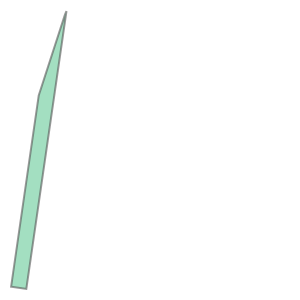

In [134]:
# what do overlaps look like?
# lets just look at the first overlap to avoid a long output cell
display(overlaps[0])

In [135]:
def calculate_coverage(overlaps, dimensions, bounds):
    
    # get dimensions of coverage raster
    mminx, mminy, mmaxx, mmaxy = bounds

    y_count, x_count = dimensions
    
    # determine pixel width and height for transform
    width = (mmaxx - mminx) / x_count
    height = (mminy - mmaxy) / y_count # should be negative

    # Affine(a, b, c, d, e, f) where:
    # a = width of a pixel
    # b = row rotation (typically zero)
    # c = x-coordinate of the upper-left corner of the upper-left pixel
    # d = column rotation (typically zero)
    # e = height of a pixel (typically negative)
    # f = y-coordinate of the of the upper-left corner of the upper-left pixel
    # ref: http://www.perrygeo.com/python-affine-transforms.html
    transform = rasterio.Affine(width, 0, mminx, 0, height, mmaxy)
    
    coverage = np.zeros(dimensions, dtype=np.uint16)
    for overlap in overlaps:
        if not overlap.is_empty:
            # rasterize overlap vector, transforming to coverage raster
            # pixels inside overlap have a value of 1, others have a value of 0
            overlap_raster = rfeatures.rasterize(
                    [sgeom.mapping(overlap)],
                    fill=0,
                    default_value=1,
                    out_shape=dimensions,
                    transform=transform)
            
            # add overlap raster to coverage raster
            coverage += overlap_raster
    return coverage


# what is a low-resolution look at the coverage grid?
display(calculate_coverage(overlaps, (6,3), aoi_shape_utm.bounds))

array([[ 0, 11,  0],
       [13, 13, 18],
       [15, 17, 18],
       [17, 16, 14],
       [17, 16, 14],
       [ 0, 21, 14]], dtype=uint16)

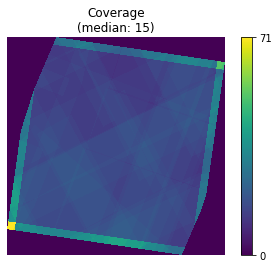

In [136]:
def plot_coverage(coverage):
    fig, ax = plt.subplots()
    cax = ax.imshow(coverage, interpolation='nearest', cmap=cm.viridis)
    ax.set_title('Coverage\n(median: {})'.format(int(np.median(coverage))))
    ax.axis('off')
    
    ticks_min = coverage.min()
    ticks_max = coverage.max()
    cbar = fig.colorbar(cax,ticks=[ticks_min, ticks_max])


plot_coverage(calculate_coverage(overlaps, dimensions, aoi_shape_utm.bounds))

Now we see the distribution of coverage of our AOI/TOI !

## Demo: Comparing Coverage

We will compare coverage of PS OrthoTiles June and July between 2016 and 2017 for the same aoi.

In [137]:
demo_aoi = test_aoi_geom  # use the same aoi that was used before

demo_aoi_shape = shape(test_aoi_geom)

proj_fcn = get_utm_projection_fcn(demo_aoi_shape)
demo_aoi_shape_utm = shapely.ops.transform(proj_fcn, demo_aoi_shape)
demo_dimensions = get_coverage_dimensions(demo_aoi_shape_utm)                               

/Users/mansi/Documents/Code/notebooks/notebooks_env/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [138]:
# create an API Request from the search specifications
# keep the same item type, geometry & cloud-cover filters as before

date_range_filter = {
"type":"DateRangeFilter",
"field_name":"acquired",
"config":{
  "gt":"2016-06-01T00:00:00Z", 
   "lt": "2016-08-01T00:00:00Z"}
}

combined_filter_2016 = {
"type":"AndFilter",
"config":[
    geom_filter,
    date_range_filter,
    cloud_cover_filter]
}

# Run the quick search
async with Session() as sess:
    cl = DataClient(sess)
    items = await cl.quick_search(name='calc_coverage_search_2016',search_filter=combined_filter_2016, item_types=item_type, limit=500)
    item_list_2016 = [i async for i in items]
    
# cache the overlaps as a list so we don't have to refetch items
overlaps_2016 = list(get_overlap_shapes_utm(item_list_2016, aoi_shape))
print(len(overlaps_2016))

/Users/mansi/Documents/Code/notebooks/notebooks_env/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


52


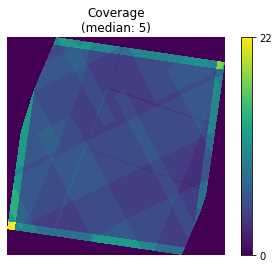

In [139]:
plot_coverage(calculate_coverage(overlaps_2016, dimensions, aoi_shape_utm.bounds))

In [140]:
# create an API Request from the search specifications
# keep the same item type, geometry & cloud-cover filters as before

date_range_filter = {
"type":"DateRangeFilter",
"field_name":"acquired",
"config":{
  "gt":"2017-06-01T00:00:00Z", 
   "lt": "2017-08-01T00:00:00Z"}
}

combined_filter_2017 = {
"type":"AndFilter",
"config":[
    geom_filter,
    date_range_filter,
    cloud_cover_filter]
}

# Run the quick search
async with Session() as sess:
    cl = DataClient(sess)
    items = await cl.quick_search(name='calc_coverage_search_2017',search_filter=combined_filter_2017, item_types=item_type, limit=500)
    item_list_2017 = [i async for i in items]
    
# cache the overlaps as a list so we don't have to refetch items
overlaps_2017 = list(get_overlap_shapes_utm(item_list_2017, aoi_shape))
print(len(overlaps_2017))

/Users/mansi/Documents/Code/notebooks/notebooks_env/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


423


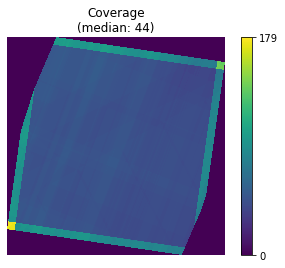

In [141]:
plot_coverage(calculate_coverage(overlaps_2017, dimensions, aoi_shape_utm.bounds))

Median coverage over 2 months has increased from 5 to almost 250! That's an increase in average revisit rate from 1+/week to 4+/day. That's what a constellation of over 100 satellites will do for you!